<a href="https://colab.research.google.com/github/mal258/machinelearning258/blob/master/Kmeans_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
#from scipy.cluster.hierarchy import fcluster
#import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet,linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc
import seaborn as sns
import hdbscan
#!pip install hdbscan
from sklearn.mixture import GaussianMixture

In [0]:
url="https://raw.githubusercontent.com/mal258/machinelearning258/master/datasets/heart.csv"
file=requests.get(url).content
heart_data=pd.read_csv(io.StringIO(file.decode('utf-8')),sep=',')

In [252]:
heart_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.891089
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.203480
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000


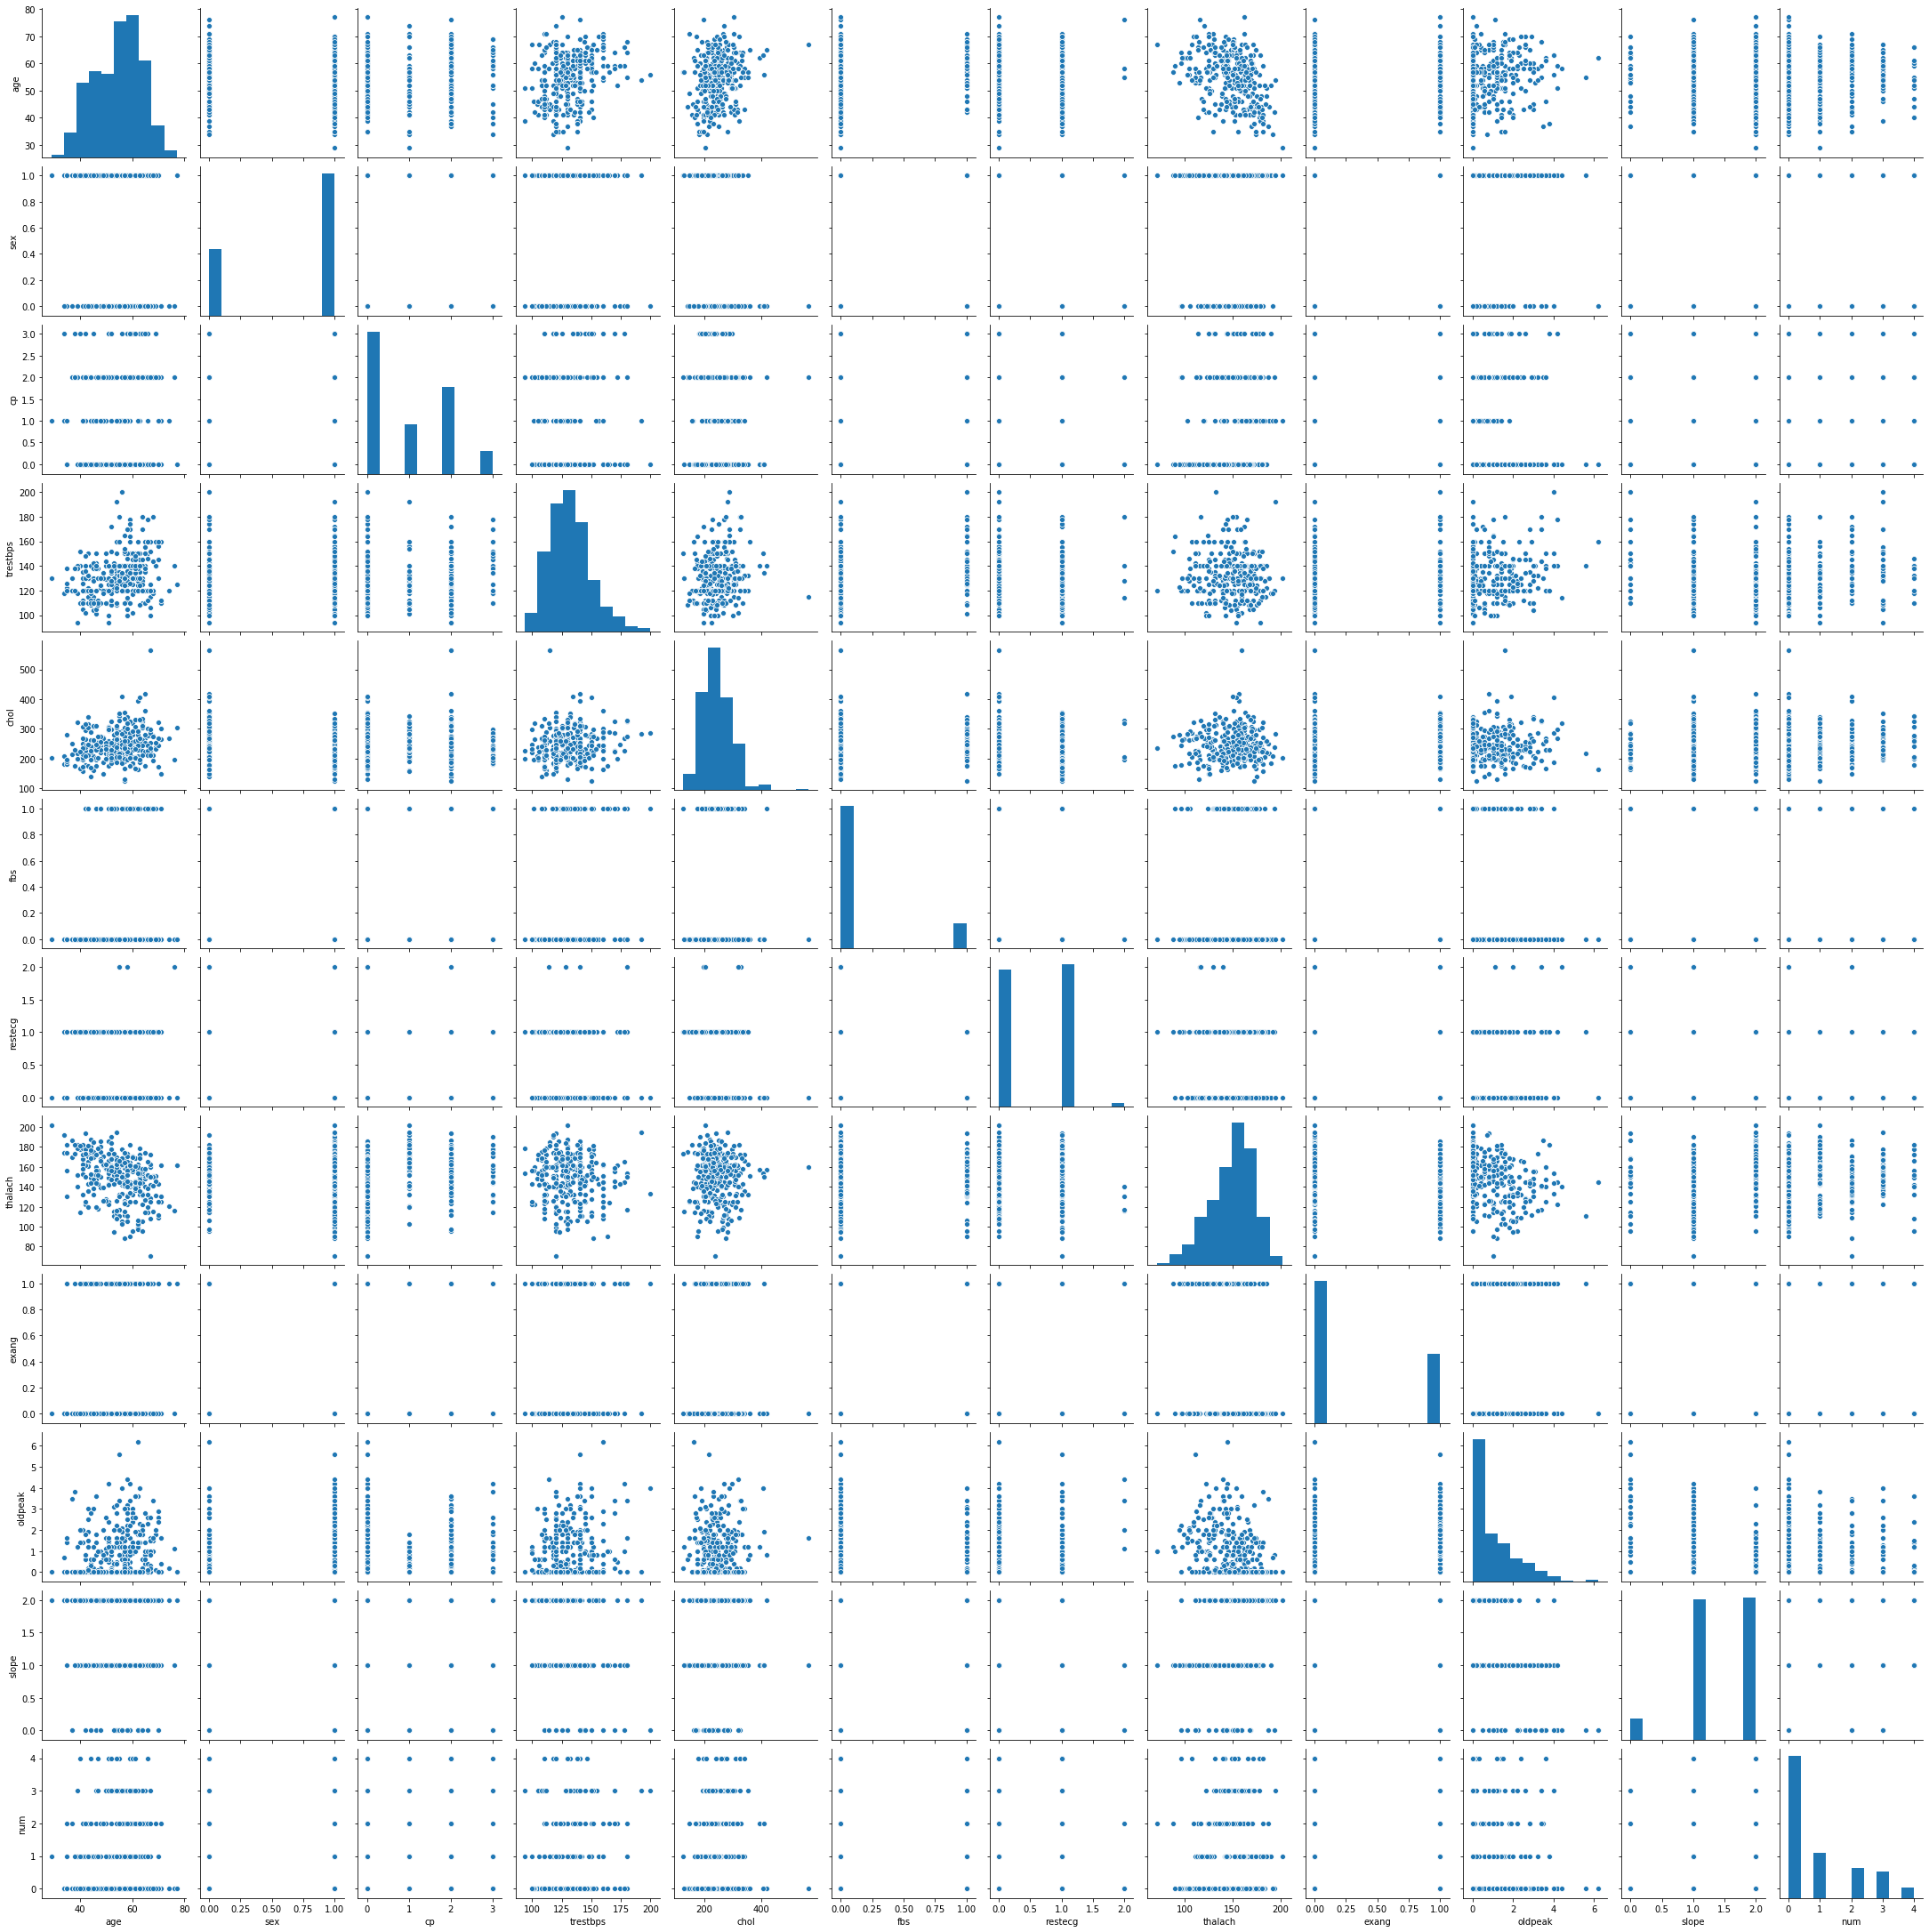

In [253]:
sns.pairplot(heart_data)

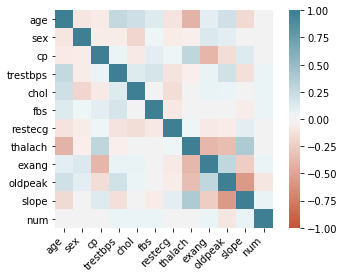

In [254]:
correlation = heart_data.corr()
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [255]:
heart_data['chol'].value_counts()

234    6
204    6
197    6
269    5
212    5
      ..
278    1
281    1
284    1
290    1
564    1
Name: chol, Length: 152, dtype: int64

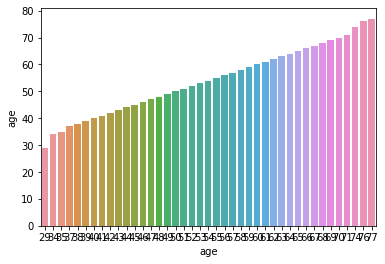

In [256]:
sns.barplot(x=heart_data.groupby('age')['sex'].count().reset_index()['age'],y=heart_data.groupby('age')['sex'].count().reset_index()['age'])

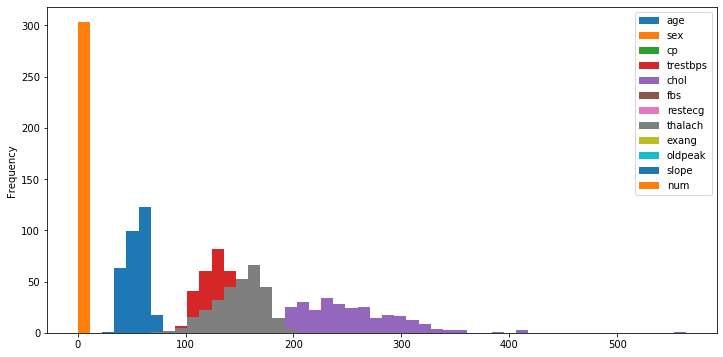

In [257]:
heart_data.plot(kind='hist',bins=50,figsize=(12,6))

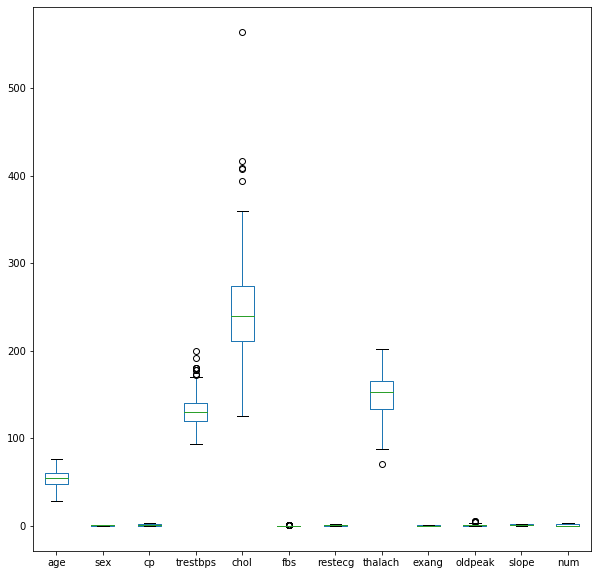

In [258]:
heart_data.plot.box(figsize=(10,10))

In [259]:
heart_data.iloc[:,[0,1,2,3,4,5,6,7]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach
0,63,1,3,145,233,1,0,150
1,37,1,2,130,250,0,1,187
2,41,0,1,130,204,0,0,172
3,56,1,1,120,236,0,1,178
4,57,0,0,120,354,0,1,163
...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123
299,45,1,3,110,264,0,1,132
300,68,1,0,144,193,1,1,141
301,57,1,0,130,131,0,1,115


In [0]:
X_heart = heart_data.iloc[:,[0,1,2,3,4,5,6,7]]

In [0]:
# Scaling Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_heart)

## Gausian Mixture Model  ---> Atul Shah

In [0]:
gmm=GaussianMixture(n_components=2, covariance_type="spherical").fit(heart_data)
labels = gmm.predict(heart_data)

No handles with labels found to put in legend.


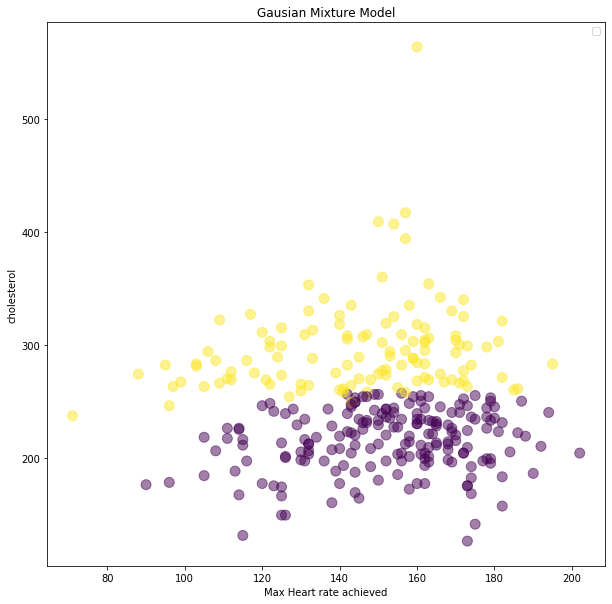

In [263]:
plt.figure(figsize=(10,10))
plt.scatter(heart_data.values[:, 7], heart_data.values[:, 4], c=labels, s=100, alpha=0.5)
plt.title('Gausian Mixture Model')
plt.xlabel('Max Heart rate achieved')
plt.ylabel('cholesterol')
plt.legend()
plt.show()

## Tensorflow Kmeans ---> Atul Shah

centroids [[5.30621762e+01 7.40932642e-01 1.05181347e+00 1.29746114e+02
  2.16259067e+02 1.55440415e-01 5.75129534e-01 1.51818653e+02
  2.84974093e-01 9.73575130e-01 1.40932642e+00 8.34196891e-01]
 [5.66545455e+01 5.81818182e-01 8.18181818e-01 1.34918182e+02
  2.98909091e+02 1.36363636e-01 4.45454545e-01 1.45836364e+02
  4.00000000e-01 1.15545455e+00 1.38181818e+00 9.90909091e-01]]


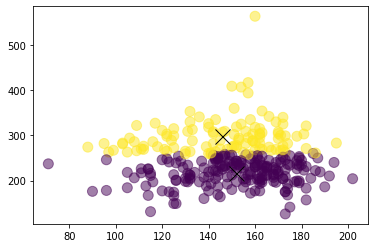

In [264]:
#points_n = 200
clusters_n = 2
iteration_n = 10
#points = tf.constant(np.random.uniform(0, 10, (points_n, 2)))
points = tf.constant(heart_data.values)
centroids = tf.Variable(tf.slice(tf.random_shuffle(points), [0, 0], [clusters_n, -1])) 
points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)
distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)
 
means = []
for c in range(clusters_n):
    means.append(tf.reduce_mean(
      tf.gather(points, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1]))
 
new_centroids = tf.concat(means, 0)
 
update_centroids = tf.assign(centroids, new_centroids)
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  for step in range(iteration_n):
    [_, centroid_values, points_values, assignment_values] = sess.run([update_centroids, centroids, points, assignments])
     
  print("centroids", centroid_values)
 
plt.scatter(points_values[:, 7], points_values[:, 4], c=assignment_values, s=100, alpha=0.5)
plt.plot(centroid_values[:, 7], centroid_values[:, 4], 'kx', markersize=15)
plt.show()

##K-means ----> Invincibles_web_md

In [0]:
from sklearn.cluster import KMeans
kmeans_heart = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10)
y_kmeans_heart = kmeans_heart.fit_predict(heart_data)

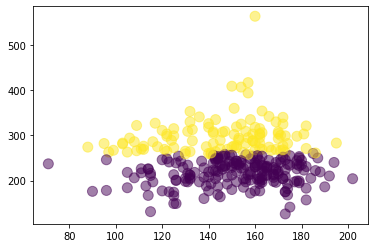

In [266]:
plt.scatter(heart_data.values[:, 7], heart_data.values[:, 4], c=y_kmeans_heart, s=100, alpha=0.5)

## Agglomerative Clustering ----> Srilalitha

In [0]:
#cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete') 
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward' ) 
y_agg=cluster.fit_predict(heart_data)

No handles with labels found to put in legend.


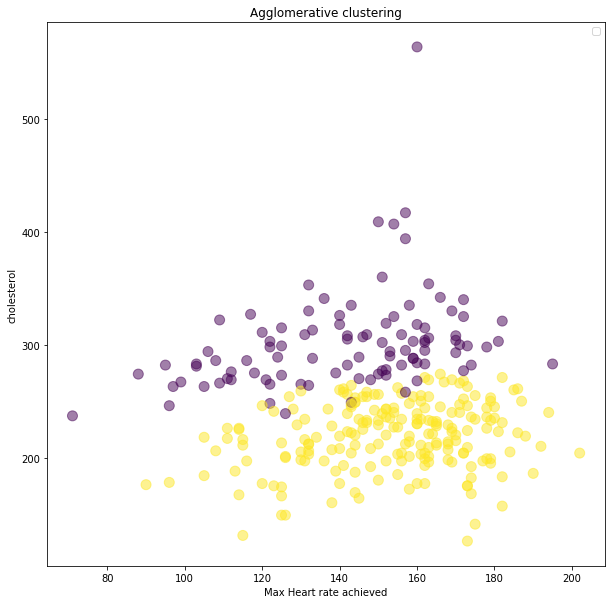

In [268]:
plt.figure(figsize=(10,10))
#plt.scatter(X_heart.iloc[y_agg == 0,7], X_heart.iloc[y_agg == 0,4], s= 100, color = 'red', label ='Need to be healthy')
#plt.scatter(X_heart.iloc[y_agg ==  1,7], X_heart.iloc[y_agg == 1,4], s= 100, color = 'blue', label ='Healthy')
#plt.scatter(X_heart.iloc[:,7], X_heart.iloc[:,4], s= 100, color = 'red', label ='Need to be healthy')
#plt.scatter(X_heart.iloc[:,7], X_heart.iloc[:,4], s= 100, color = 'blue', label ='Healthy')
plt.scatter(heart_data.values[:, 7], heart_data.values[:, 4], c=y_agg, s=100, alpha=0.5)
plt.title('Agglomerative clustering')
plt.xlabel('Max Heart rate achieved')
plt.ylabel('cholesterol')
plt.legend()
plt.show()

##Tensorflow Kmeans ---> Srilalitha

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxdos6fvw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdb9e1f3a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done c

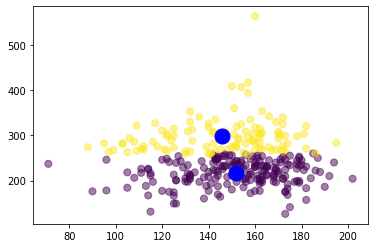

In [269]:
import tensorflow as tf
from tensorflow.contrib.factorization import KMeans
heart_data.values

def input_fn():
  return tf.compat.v1.train.limit_epochs(
      tf.convert_to_tensor(heart_data.values, dtype=tf.float32), num_epochs=1)

num_clusters = 2
kmeans = tf.contrib.factorization.KMeansClustering(
    num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
  kmeans.train(input_fn)


assignments = list(kmeans.predict_cluster_index(input_fn=input_fn))
centroid_values = kmeans.cluster_centers()
print(assignments)
assignments.count(0)

plt.scatter(heart_data.values[:, 7], heart_data.values[:, 4], c=assignments, s=50, alpha=0.5)
plt.plot(centroid_values[:, 7], centroid_values[:, 4], 'bo', markersize=15)
plt.show()


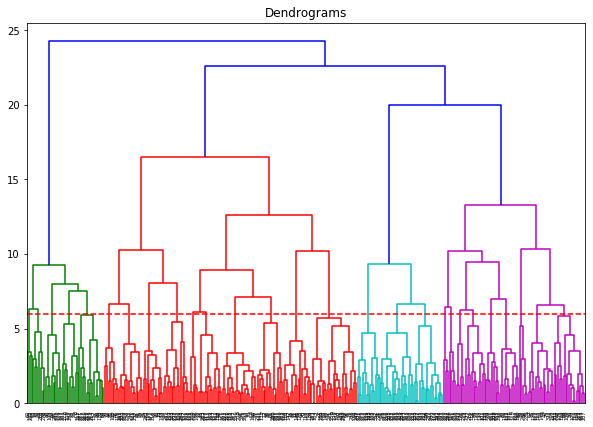

In [270]:
# Hiearachial Clustering Dendrogram
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')

##DBSCAN ----> Shreyus 

In [0]:
# DBSCAN Clustering
#dbscan = DBSCAN(eps=0.01,min_samples=2)
dbscan = DBSCAN(eps=30,min_samples=20, algorithm="kd_tree")
db_clusters = dbscan.fit_predict(heart_data)

In [0]:
X_db_scaled['clusters']=db_clusters

Text(0, 0.5, 'Feature 1')

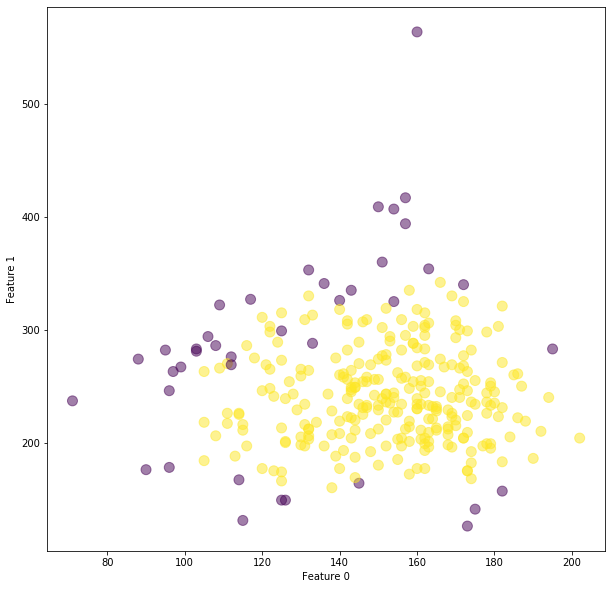

In [273]:
# plot the cluster assignments
#plt.scatter(X_heart['trestbps'], X_heart['thalach'], c=db_clusters, cmap="plasma")
plt.figure(figsize=(10, 10))
plt.scatter(heart_data.values[:, 7], heart_data.values[:, 4], c=db_clusters, s=100, alpha=0.5)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

##Tensorflow Kmeans ---> Shreyus 

centroids [[5.65000000e+01 6.01694915e-01 8.47457627e-01 1.34567797e+02
  2.96025424e+02 1.44067797e-01 4.15254237e-01 1.46135593e+02
  3.89830508e-01 1.13050847e+00 1.38983051e+00 9.91525424e-01]
 [5.30054054e+01 7.35135135e-01 1.04324324e+00 1.29745946e+02
  2.14524324e+02 1.51351351e-01 6.00000000e-01 1.51886486e+02
  2.86486486e-01 9.81621622e-01 1.40540541e+00 8.27027027e-01]]


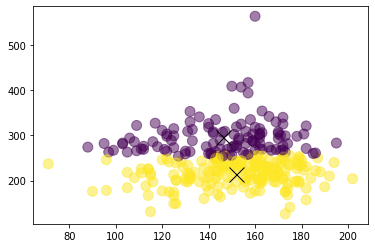

In [274]:
#points_n = 200
clusters_n = 2
iteration_n = 10
#points = tf.constant(np.random.uniform(0, 10, (points_n, 2)))
points = tf.constant(heart_data.values)
centroids = tf.Variable(tf.slice(tf.random_shuffle(points), [0, 0], [clusters_n, -1])) 
points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)
distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)
 
means = []
for c in range(clusters_n):
    means.append(tf.reduce_mean(
      tf.gather(points, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1]))
 
new_centroids = tf.concat(means, 0)
 
update_centroids = tf.assign(centroids, new_centroids)
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  for step in range(iteration_n):
    [_, centroid_values, points_values, assignment_values] = sess.run([update_centroids, centroids, points, assignments])
     
  print("centroids", centroid_values)
 
plt.scatter(points_values[:, 7], points_values[:, 4], c=assignment_values, s=100, alpha=0.5)
plt.plot(centroid_values[:, 7], centroid_values[:, 4], 'kx', markersize=15)
plt.show()

##HDBSCAN -----> Shailesha

In [0]:
hdb_scan = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_epsilon=60, min_samples=20)

In [0]:
hdb = hdb_scan.fit(heart_data)

Text(0, 0.5, 'Feature 1')

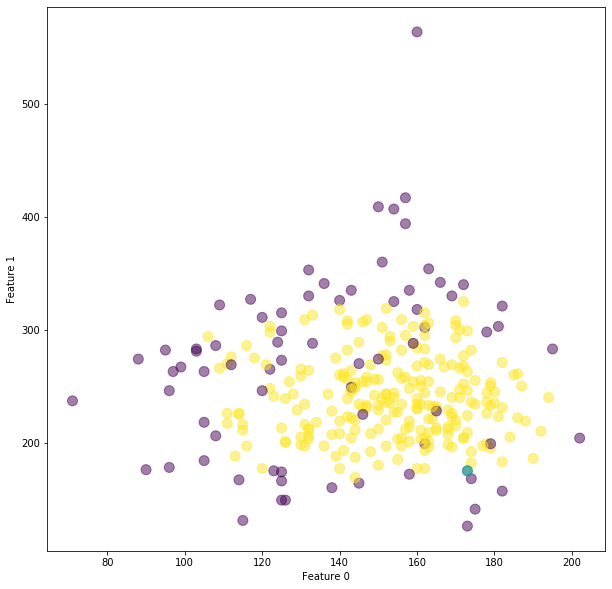

In [277]:
#plt.scatter(X_heart['trestbps'], X_heart['thalach'], c=hdbscan.labels_, cmap="plasma")
plt.figure(figsize=(10, 10))
plt.scatter(heart_data.values[:, 7], heart_data.values[:, 4], c=hdb.labels_, s=100, alpha=0.5)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

##K-means tensorflow -----> Shailesha

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpaksphz2p', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdc0239ef28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done c

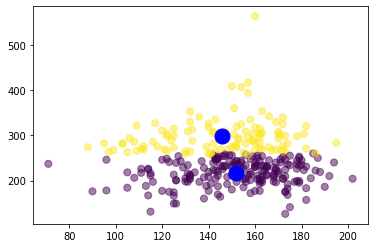

In [278]:

import tensorflow as tf
from tensorflow.contrib.factorization import KMeans
heart_data.values

def input_fn():
  return tf.compat.v1.train.limit_epochs(
      tf.convert_to_tensor(heart_data.values, dtype=tf.float32), num_epochs=1)

num_clusters = 2
kmeans = tf.contrib.factorization.KMeansClustering(
    num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
  kmeans.train(input_fn)


assignments = list(kmeans.predict_cluster_index(input_fn=input_fn))
centroid_values = kmeans.cluster_centers()
print(assignments)
assignments.count(0)

plt.scatter(heart_data.values[:, 7], heart_data.values[:, 4], c=assignments, s=50, alpha=0.5)
plt.plot(centroid_values[:, 7], centroid_values[:, 4], 'bo', markersize=15)
plt.show()
